# Importation des données

In [21]:
import os
import string
import re
import math
from math import sqrt
import numpy as np
import random
import time
import pandas as pd
import nltk, re, pprint
#nltk.download('punkt')
from nltk import word_tokenize
random.seed(1)
np.random.seed(1)

import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline 
#useless ?

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

import pickle

#PCA & TSNE : 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.stats import spearmanr

import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import seaborn as sns

import gensim
from gensim.models import word2vec

import rpy2.robjects as r

In [22]:
#nom_dossier = "100k"
nom_dossier = "ens"

gensim_utile = True #True pour le modèle google, False pour le modele ARK

#os.chdir('C:/Users/torna/Documents/StatApp/StatApp')
os.chdir('/Users/alainquartierlatente/Desktop/Ensae/StatApp')
#os.chdir('C:/Users/Kim Antunez/Documents/Projets_autres/StatApp')
#os.chdir('/home/aqlt/Documents/Ensae/StatApp')


with open("data/corpus_trie%s.file" %nom_dossier, "rb") as f:
    corpus = pickle.load(f) 
ens_tweets = [phrase.split() for phrase in corpus]
len(ens_tweets)

1348627

On crée index_mot et mot_index

In [23]:
phrases = ens_tweets
words = [item for sublist in phrases for item in sublist]
print(type(words))
with open('data/%s/vocabulary.file' %nom_dossier, "rb") as f:
    vocabulary = pickle.load(f) 
index_mot = {index: w for (index, w) in enumerate(vocabulary)}
mot_index = {w: index for (index, w) in enumerate(vocabulary)}
print("Nombre de mots :", len(words))
print("Taille du vocabulaire :", len(vocabulary))
fdist = nltk.FreqDist(words)

<class 'list'>
Nombre de mots : 31390592
Taille du vocabulaire : 70330


In [24]:
print(fdist.most_common(100))

[('nickname', 1542945), ('de', 1097380), ('lowfrequencyword', 1082919), ('le', 712091), ('est', 589701), ('je', 541570), ('les', 509159), ('c', 493644), ('la', 485258), ('j', 475754), ('à', 463614), ('pas', 453761), ('en', 332771), ('que', 330610), ('un', 301553), ('et', 300208), ('a', 285976), ('ça', 261630), ('il', 249708), ('ai', 246562), ('l', 241270), ('mais', 230924), ('pour', 220047), ('tu', 202209), ('d', 197925), ('on', 195768), ('une', 185405), ('😂', 182836), ('me', 162163), ('ce', 158652), ('😭', 154803), ('qui', 153344), ('t', 144630), ('dans', 133250), ('sur', 132826), ('plus', 132698), ('moi', 123416), ('qu', 122897), ('mon', 121416), ('y', 118672), ('suis', 117578), ('fait', 113295), ('trop', 109829), ('avec', 109023), ('vous', 108423), ('bien', 107295), ('ma', 98729), ('si', 96658), ('tout', 93320), ('va', 88117), ('elle', 88025), ('m', 87131), ('même', 84683), ('faire', 83027), ('bon', 76618), ('quand', 75479), ('ne', 74787), ('toi', 74705), ('merci', 73715), ('mdr', 70

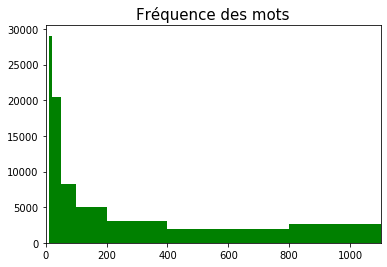

In [25]:
import matplotlib.pyplot as plt
plt.hist(fdist.values(), bins=[0,10,20,50, 100, 200,400,800,max(fdist.values())],color='g') #width=100, range=(0, 50000)
plt.xlim(xmin=0, xmax = 1100)
plt.title('Fréquence des mots', fontsize=15)
plt.show()

# Fonctions générales

## 1. Distances

Pour tester la similarité entre deux mots, on calcule la **similarité cosinus** entre leur représentation vectorielle :
$$
\frac{A \cdot B}{|| A || \cdot || B ||}
$$

On peut également calculer la **distance euclidienne** pour comparer les résultats avec ces deux métriques

In [26]:
def cos_distance(u, v):
    return (np.dot(u, v)  / (math.sqrt(np.dot(u, u)) *  (math.sqrt(np.dot(v, v)))))

#def eucl_distance(u, v):
#    return (1/(np.linalg.norm(u/np.dot(u, u)-v/np.dot(v, v)))+1)
def eucl_distance(u, v):
    return (-np.linalg.norm(u/np.dot(u, u)-v/np.dot(v, v)))

Cette fonction permet d'afficher les n mots les plus proche d'un mot (distance cosinus ou euclidienne)

In [27]:
def mot_plus_proche(word, n=10, distance="cos"):
    word_distance = {}
    for mot in mot_poids:
        if mot != word:
            if distance == "cos":
                word_distance[mot] = (cos_distance(mot_poids[mot],(mot_poids[word])))
            else:
                word_distance[mot] = (eucl_distance(mot_poids[mot],(mot_poids[word])))
    word_distance = sorted(word_distance.items(), key=lambda t: t[1],reverse=True)
    return word_distance[0:n]

Cette fonction permet de calculer la distance entre deux mots. 

In [28]:
def distance_mots(word1,word2, mot_poids, distance="cos"):
    if word1 in mot_poids.keys() and word2 in mot_poids.keys():
        if(distance=="cos"):
            word_distance = (cos_distance(mot_poids[word1],(mot_poids[word2])))
        else:
            word_distance = (eucl_distance(mot_poids[word1],(mot_poids[word2])))
    else:
        word_distance = float('nan')
    return word_distance
distance_mots_v = np.vectorize(distance_mots)

# Evaluer un seul modèle 

Ecrire les bilans ici : https://github.com/AQLT/StatApp/blob/master/Code/Parametres%20lances.md


## 1. Charger le modèle


Paramètres à modifier 

In [17]:
if gensim_utile: # Pour le modèle Google
    # renseigner dans l'ordre : dim, epoch, window, learning_rate
    simul = [50,100,3,0.01] # une seule simulation dans cette partie
    dim = simul[0]
    epoch = simul[1]
    window = simul[2]
    learning_rate = simul[3]
    seed = 1
else: # Pour le modèle ARK (à modifier ultérieurement avec nouveau nommage)
    numero_simulation = 2
    seed = 1
    derniere_epoch = 10 

In [18]:
if gensim_utile: # Pour le modèle Google
    chemin = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed{}".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:], seed)  
    model = gensim.models.keyedvectors.KeyedVectors.load(chemin + "/word2vec.model")
    py_list = []
    for mot in vocabulary:
         py_list.append(model.wv[mot].tolist())   
    mat_finale = torch.FloatTensor(py_list)
else: # Pour le modèle ARK (à modifier ultérieurement avec nouveau nommage)
    with open('data/%s/Simulation_%i_seed%i/input_%i.file' %(nom_dossier, numero_simulation, seed, derniere_epoch) , "rb") as f:
        input = pickle.load(f)
    with open('data/%s/Simulation_%i_seed%i/output_%i.file' %(nom_dossier, numero_simulation, seed, derniere_epoch), "rb") as f:
        output = pickle.load(f)
    mat_finale = (input+output)/2 
    
mot_poids = {index_mot[index]: poids.detach().numpy() for (index, poids) in enumerate(mat_finale)}

## 2. Mots les plus proches

In [19]:
mots = ["tweet", "bonjour", "wesh", "gros", "grosse", "femme","romain"]
for mot in mots:
    if mot in mot_index:
        print('Pour le mot "%s"' %mot + " (%i apparitions), les mots les plus proches sont : " %fdist[mot])
        print('cosinus :',mot_plus_proche(mot,distance = "cos"))
        print('euclidienne :',mot_plus_proche(mot,distance = "eucl"))
        print("\n")

Pour le mot "tweet" (443 apparitions), les mots les plus proches sont : 
cosinus : [('moment', 0.6805506489232854), ('compte', 0.6688256670027419), ('truc', 0.6507544870192552), ('gif', 0.6460773774192753), ('sujet', 0.6410251655792448), ('jeu', 0.6388608268847146), ('message', 0.6275034988816303), ('thread', 0.6188455860900698), ('prénom', 0.616810433684892), ('point', 0.6162050302704436)]
euclidienne : [('moment', 15.788851251961027), ('compte', 14.754661748162862), ('point', 14.489669002020971), ('truc', 14.480603501741951), ('message', 14.394171430932278), ('sujet', 13.765110010823232), ('avis', 13.524844862211776), ('site', 13.43278111719257), ('nom', 13.323595061590554), ('gif', 13.275124006276132)]


Pour le mot "bonjour" (619 apparitions), les mots les plus proches sont : 
cosinus : [('bonsoir', 0.8110209546792099), ('hello', 0.6777080233953401), ('coucou', 0.5558127489802244), ('navré', 0.5447743563561549), ('contacter', 0.5402266269500443), ('😗', 0.5304396442020917), ('passez

## 3. Réduction de dimension (ACP, TSNE)

### A. Listes de mots utilisées

**Liste 1** correspond à une liste de mot que nous choississons nous-même d'évaluer. 

In [20]:
liste1 = [["poli","courtois","bonjour","salut"],["canapé","fauteuil","table","chaise"],
    ["téléphone","portable","numéro","appel"],["voiture","camion","vélo","train"],
         ["beau","mignon","bg","mannequin"],["docteur","médecin","santé","bobo"],
         ["belle","jolie","mignonne","bellegosse"],["père","papa","daron"],
         ["mère","maman","daronne"],["ol","psg","foot","stade"]]

#liste1 = [["homme","femme", "enfant"],["chien","chat"],
#         ["vanille","chocolat"],
#    ["poli","courtois"],["bonjour","salut"],["propre","sale"],["canapé","fauteuil"],
#    ["téléphone","portable"],["voiture","camion"],["grand","petit"]]

#liste1 = [["homme", "tttttttttt","femme","sexe","genre","mari","épouse","famille","inégalités","enfant","amour","couple","différence"],
#    ["chien","chat","animal","domestique","maison","aboyer","miauler","labrador","poil","pattes","spa","ami"],
#    ["vanille","chocolat","parfum","goût","fraise","glace","boule","gâteau","bonbon","blanc","noir","préférence"],
#    ["poli","courtois","bonjour","merci","pardon","stp","règles","apprendre","savoir-vivre","savoir-être","formule","demander"],
#    ["choqué","horrifié","peur","terreur","phobie","clown","noir","araignée","rat","cri","oh","ah"],
#    ["propre","sale","nettoyer","vaisselle","laver","savon","produit","salissures","traces","net","éclatant","brillant"],
#    ["canapé","fauteuil","maison","salon","assis","confortable","sofa","convertible","cuir","télé","accoudoir","plaid"],
#    ["téléphone","portable","appel","allo","décrocher","sms","numéro","mobile","orange","sfr","free","bouygues"],
#    ["voiture","camion","moto","véhicule","conduire","rouler","conducteur","volant","chauffeur","permis","vitesse","passager"],
#    ["grand","petit","taille","géant","nain","s","m","l","xl","mesure","énorme","longueur"]
#]

**Liste 2** tire au sort une liste de mots regroupés selon leur fréquence d'apparition. 

In [21]:
np.random.seed(1)

mots0_20 = dict()
mots20_100 = dict()
mots100_1000 = dict()
mots1000_max = dict()

for (key, value) in fdist.items():
    if value <= 20 :
        mots0_20[key] = value
    if value > 20 and value <= 100 :
        mots20_100[key] = value
    if value > 100 and value <= 1000 :
        mots100_1000[key] = value        
    if value > 1000 :
        mots1000_max[key] = value


liste_0_20 = list(np.random.choice(list(mots0_20.keys()), size=100))
liste_20_100 = list(np.random.choice(list(mots20_100.keys()), size=100))
liste_100_1000 = list(np.random.choice(list(mots100_1000.keys()), size=100))
liste_1000_max = list(np.random.choice(list(mots1000_max.keys()), size=100))

liste2 = [liste_0_20, liste_20_100, liste_100_1000, liste_1000_max]

### B. ACP

In [22]:
def ACP(liste, statique = True, nom_couples_explicite=True):
    # On enlève les mots qui n'existent pas
    liste_triee =[]
    for couple in liste:
        liste_triee.append([w for w in couple if w in mot_index]) 
    liste_mots = [w for couple in liste_triee for w in couple]

    df_res = pd.DataFrame.from_dict(mot_poids).transpose()
    df_res = df_res.loc[liste_mots]
    df_res['label'] = 'Autre' 

    if nom_couples_explicite:
        for couple in liste_triee:
            df_res.loc[couple,'label'] = '/'.join(couple)
    else:
        for i in range(0, len(liste_triee)):
            df_res.loc[liste_triee[i],'label'] = "Couple %i" %i        

    features = list(range(0, len(liste_triee)))
    # Separating out the features
    x = df_res.loc[:, features].values
    # Separating out the target
    y = df_res.loc[:,['label']].values
    # Standardizing the features
    x = StandardScaler().fit_transform(x)

    pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents
                 , columns = ['Axe 1', 'Axe 2'])

    df_res['mot'] = df_res.index.values
    df_res = df_res.reset_index()

    finalDf = pd.concat([principalDf, df_res[['label','mot']]],  axis = 1)

    if statique:
        # Représentation simple statique 
        fig = plt.figure(figsize = (12,8))

        g = sns.scatterplot(x="Axe 1", y="Axe 2",
                        hue="label", data=finalDf, s = 150)
        handles, labels = g.get_legend_handles_labels()
        box = g.get_position()
        g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

        # Put a legend to the right side
        g.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1,
                 handles=handles[1:], labels=list(dict.fromkeys(finalDf["label"])))
    else:
        init_notebook_mode(connected=True)

        cf.go_offline()
        cf.set_config_file(offline=False, world_readable=True)

        #Travailler avec sous-table sinon trop lourd
        #subFinalDf = pd.concat([finalDf[(finalDf['label'] != "Autre")],finalDf.iloc[1:100:]],  axis = 0)
        subFinalDf = pd.concat([finalDf],  axis = 0)

        subFinalDf.iplot(kind='scatter',
                      mode='markers',
                      x='Axe 1',
                      y='Axe 2',
                      categories='label',
                      text='mot',
                      xTitle='Axe 1',
                      yTitle='Axe 2',
                      title='ACP en 2 composantes',
                      filename='cufflinks/simple-scatter')


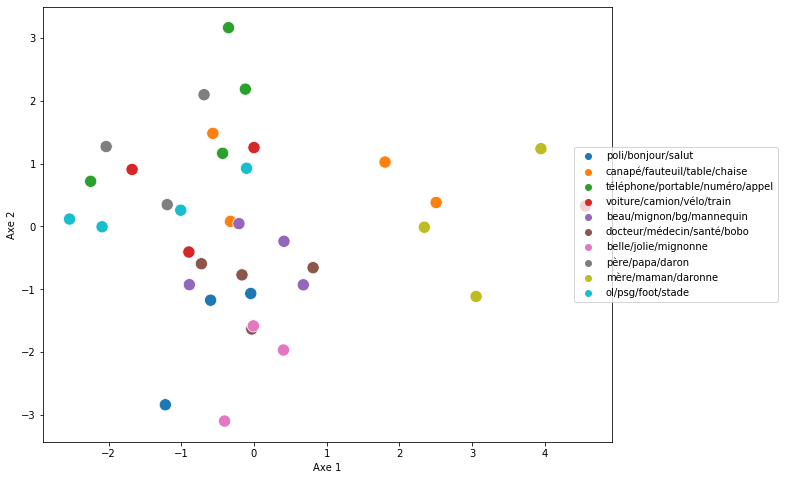

In [23]:
ACP(liste1, statique = True)

In [30]:
ACP(liste1, statique = False)

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:808: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:811: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



In [31]:
ACP(liste2, statique = False)

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:808: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:811: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



## 4. TSNE 

In [24]:
def tsne_graph(liste, statique = True, nom_couples_explicite=True):
    liste_triee =[]
    for couple in liste:
        liste_triee.append([w for w in couple if w in mot_index])
    liste_mots = [w for couple in liste_triee for w in couple]
    df_res = pd.DataFrame.from_dict(mot_poids).transpose()
    df_res = df_res.loc[liste_mots]
    df_res['label'] = 'Autre' 

    if nom_couples_explicite:
        for couple in liste_triee:
            df_res.loc[couple,'label'] = '/'.join(couple)
    else:
        for i in range(0, len(liste_triee)):
            df_res.loc[liste_triee[i],'label'] = "Couple %i" %i  
    features = list(range(0, len(liste)))
    # Separating out the features
    data_x = df_res.loc[:, features].values
    # Separating out the target
    data_y = df_res.loc[:,['label']].values

    tsne = TSNE(n_components=2, random_state=0)
    tsne_obj= tsne.fit_transform(data_x)

    test_features = [[i+1]*len(liste_triee[i]) for i in range(0, len(liste_triee))]
    test_features = [i for f in test_features for i in f]
    tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                            'Y':tsne_obj[:,1],
                           'digit':test_features})
    tsne_df["legend"] = tsne_df["digit"]
    for i in range(0,len(tsne_df)):
        tsne_df["legend"][i]= "Couple %i" %tsne_df["digit"][i]
    if statique:
        fig = plt.figure(figsize = (12,8))
        g = sns.scatterplot(x="X", y="Y",
                            hue = "legend",
                            data=tsne_df);
        handles, labels = g.get_legend_handles_labels()
        box = g.get_position()
        g.set_position([box.x0, box.y0, box.width * 0.85, box.height]) # resize position

        # Put a legend to the right side
        g.legend(loc='center right', bbox_to_anchor=(1.3, 0.5), ncol=1,
                 handles=handles[1:], labels=list(dict.fromkeys(tsne_df["legend"])))
    else:
        tsne_df["mot"] = liste_mots
        cf.go_offline()
        cf.set_config_file(offline=False, world_readable=True)

        #Travailler avec sous-table sinon trop lourd
        subFinalDf = pd.concat([tsne_df],  axis = 0)

        subFinalDf.iplot(kind='scatter',
                      mode='markers',
                      x='X',
                      y='Y',
                      categories='legend',
                      text='mot',
                      xTitle='Axe 1',
                      yTitle='Axe 2',
                      title='TSNE',
                      filename='cufflinks/simple-scatter')

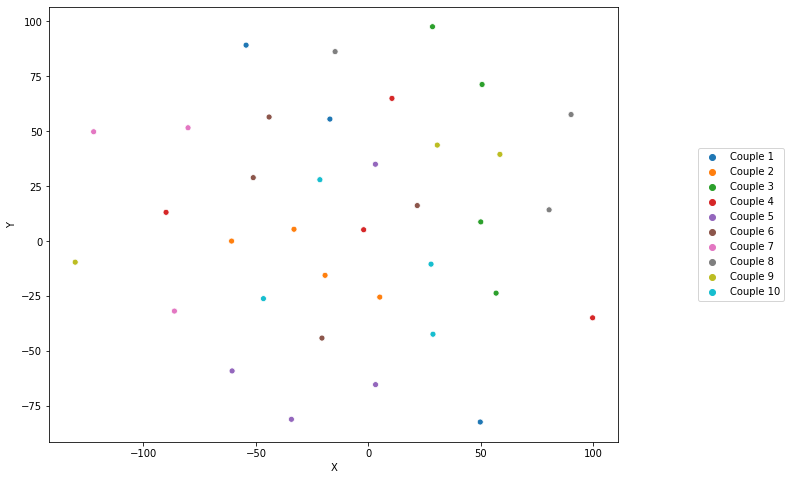

In [33]:
tsne_graph(liste1, statique = True,
           nom_couples_explicite = True) #Paramètre ne marche pas : a debuger ?

In [34]:
tsne_graph(liste1, statique = False,
           nom_couples_explicite = True) #Paramètre ne marche pas : a debuger ?


C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:808: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:811: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



In [35]:
tsne_graph(liste2, statique = False,
           nom_couples_explicite = True)#Paramètre ne marche pas : a debuger ?

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:808: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead

C:\Users\Kim Antunez\Anaconda3\lib\site-packages\cufflinks\plotlytools.py:811: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



## 5. Human judgement

In [29]:
df_base = pd.read_csv('data_bis/word_similarity.csv', sep=";")
df_base

,word1,word2,corr
0,corde,sourire,0.00
1,midi,ficelle,0.00
2,coq,périple,0.06
3,fruit,fournaise,0.11
4,autographe,rivage,0.00
...,...,...,...
60,coussin,oreiller,3.00
61,cimetière,cimetière,4.00
62,automobile,auto,3.94
63,joyau,bijou,3.22


In [30]:
distance_mots_v = np.vectorize(distance_mots)
df = df_base
df["corr_word2vec_cos"] = distance_mots_v(df["word1"],df["word2"], mot_poids, "cos")
df["corr_word2vec_eucl"] = distance_mots_v(df["word1"],df["word2"], mot_poids, "eucl")
print(len(df))
df = df.dropna()
print(len(df))
df

NameError: name 'mot_poids' is not defined

In [20]:
#On fait des tests à 5 % pour la distance cosinus
alpha = 0.05
corr, p_value = spearmanr(df["corr"], df["corr_word2vec_cos"])
if p_value > alpha:
    print('Le résultat de word2vec COSINUS est différent de celui du human judgement (non rejet de H0 = non corrélation) p=%.3f' % p_value,'/ Valeur de la corrélation : %.3f'% corr)
else:
    print('Le résultat de word2vec COSINUS est semblable celui du human judgement (rejet de H0 = non corrélation) p=%.3f' % p_value,'/ Valeur de la corrélation : %.3f'% corr)

print("\n")

#On fait des tests à 5 % pour la distance euclidienne
alpha = 0.05
corr, p_value = spearmanr(df["corr"], df["corr_word2vec_eucl"])
if p_value > alpha:
    print('Le résultat de word2vec EUCLIDIEN est différent de celui du human judgement (non rejet de H0 = non corrélation) p=%.3f' % p_value,'/ Valeur de la corrélation : %.3f'% corr)
else:
    print('Le résultat de word2vec COSINUS est semblable celui du human judgement (rejet de H0 = non corrélation) p=%.3f' % p_value,'/ Valeur de la corrélation : %.3f'% corr)

KeyError: 'corr_word2vec_cos'

# Evaluer plusieurs modèles 

## 1. Evaluation par le "human judgement"


In [31]:
#https://zhiyzuo.github.io/Pearson-Correlation-CI-in-Python/
#r.r['cor.test'](r.vectors.FloatVector(x),r.vectors.FloatVector(y),method="pearson")

from scipy import stats

def pearsonr_ci(x,y,alpha=0.05):
    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return lo, hi

#pearsonr_ci(np.array([1,2,3]),np.array([3,2,1]))

In [32]:
def ic_modele(chemin, distance="cos", gensimbool = gensim_utile, epoch_max = 50, seeds=[1,5,10,15,20,25]):
    if gensimbool:
        df_petit = pd.read_csv('data_bis/word_similarity.csv', sep=";")
        df_petit["corr"]=df_petit["corr"].rank(method="min")
        df = pd.DataFrame()
        for i in seeds:
            df = df.append(df_petit)               
        vecteur_cos = [] 
        df2 = pd.DataFrame()
        for i in seeds:
            isdir = os.path.isdir(chemin+"_seed"+str(i))
            if isdir:
                model = gensim.models.keyedvectors.KeyedVectors.load(chemin+"_seed"+str(i) + "/word2vec.model")
                py_list = []
                for mot in vocabulary:
                    py_list.append(model.wv[mot].tolist()) 
                mat_finale = torch.FloatTensor(py_list)
                mot_poids = {index_mot[index]: poids.detach().numpy() for (index, poids) in enumerate(mat_finale)}
                dfprov = pd.DataFrame(distance_mots_v(df_petit["word1"],df_petit["word2"], mot_poids, distance),columns=["corr_word2vec"])
                dfprov["corr_word2vec"]=dfprov["corr_word2vec"].rank(method="min")
                df2 = df2.append(dfprov)
        df = pd.concat([df, df2], axis=1)
        df = df.dropna()
        ic = pearsonr_ci(df["corr"], df["corr_word2vec"])
    else:
        isdir = os.path.isdir(chemin)
        if isdir:
            for i in range(epoch_max):
                try:
                    with open('{}/input_{}.file'.format(chemin, i+1), "rb") as f:
                        input = pickle.load(f)
                    with open('{}/output{}.file'.format(chemin, i+1), "rb") as f:
                        output = pickle.load(f)
                    mat_finale = (input+output)/2
                    mot_poids = {index_mot[index]: poids.detach().numpy() for (index, poids) in enumerate(mat_finale)}
                    df = pd.read_csv('data_bis/word_similarity.csv', sep=";")
                    df["corr_word2vec"] = distance_mots_v(df["word1"],df["word2"], mot_poids, distance)
                    df = df.dropna()
                    corr, p_value = spearmanr(df["corr"], df["corr_word2vec"])
                    all_cor.append(corr)
                    all_p_val.append(p_value)
                except OSError:
                    break;     

    return(ic);

#chemin = "C:/Users/Kim Antunez/Documents/Projets_autres/StatApp/data/ens/gensim/dim50_ep100_w7_lr02"
#ic_modele(chemin, distance="cos", gensimbool = gensim_utile, epoch_max = 50, seeds=[1,5,10,15,20,25])

In [46]:
chemin = "data/ens/gensim/dim50_ep100_w4_lr005"
ic = ic_modele(chemin, distance="cos", gensimbool = gensim_utile, epoch_max = 50, seeds=[1,5,10,15,20,25])
ic

(0.3234259823631521, 0.5068380326815431)

In [34]:
ic[0]

0.3689075222989219

In [35]:
def corr_modele(chemin, distance="cos", gensimbool = gensim_utile, epoch_max = 50):  
    all_cor = []
    all_p_val = []
    if gensimbool:
        #chemin = "data/" + nom_dossier + "/gensim/Simulation_" + str(numero_simulation) + dossier
        #chemin = "data/{}/gensim/dim{}_ep{}_w{}_lr{}_seed{}".format(nom_dossier, dim, epoch, window, str(learning_rate)[2:], seed)  
        isdir = os.path.isdir(chemin)
        if isdir:
            model = gensim.models.keyedvectors.KeyedVectors.load(chemin + "/word2vec.model")
            py_list = []
            for mot in vocabulary:
                py_list.append(model.wv[mot].tolist())   
            mat_finale = torch.FloatTensor(py_list)
            mot_poids = {index_mot[index]: poids.detach().numpy() for (index, poids) in enumerate(mat_finale)}
            df = pd.read_csv('data_bis/word_similarity.csv', sep=";")
            df["corr_word2vec"] = distance_mots_v(df["word1"],df["word2"], mot_poids, distance)
            df = df.dropna()
            corr, p_value = spearmanr(df["corr"], df["corr_word2vec"])
            all_cor.append(corr)
            all_p_val.append(p_value)
    else:
        isdir = os.path.isdir(chemin)
        if isdir:
            for i in range(epoch_max):
                try:
                    with open('{}/input_{}.file'.format(chemin, i+1), "rb") as f:
                        input = pickle.load(f)
                    with open('{}/output{}.file'.format(chemin, i+1), "rb") as f:
                        output = pickle.load(f)
                    mat_finale = (input+output)/2
                    mot_poids = {index_mot[index]: poids.detach().numpy() for (index, poids) in enumerate(mat_finale)}
                    df = pd.read_csv('data_bis/word_similarity.csv', sep=";")
                    df["corr_word2vec"] = distance_mots_v(df["word1"],df["word2"], mot_poids, distance)
                    df = df.dropna()
                    corr, p_value = spearmanr(df["corr"], df["corr_word2vec"])
                    all_cor.append(corr)
                    all_p_val.append(p_value)
                except OSError:
                    break;     
        
    return([all_cor, all_p_val]);

#corr_modele("data/100k/gensim/dim20_ep10_w3_lr01_seed1", distance="cos", gensimbool = True, epoch_max = 50)

In [49]:
def tableau_corr_hji(dim = "\d*", epoch = "\d*", window = "\d*",
                     learning_rate = "\d*", seed = "\d*",
                     distance="cos", index = "seed", gensimbool = gensim_utile):    
    if(isinstance(learning_rate, float)):
        learning_rate = str(learning_rate)[2:]
    if(isinstance(dim, list)):
        dim = r.r['paste0']("(",r.r['paste0']("(",dim,")",collapse = "|"),")")[0]
    if(isinstance(epoch, list)):
        epoch = r.r['paste0']("(",r.r['paste0']("(",epoch,")",collapse = "|"),")")[0]
    if(isinstance(window, list)):
        window = r.r['paste0']("(",r.r['paste0']("(",window,")",collapse = "|"),")")[0]
    if(isinstance(learning_rate, list)):
        learning_rate = [str(lr)[2:] if isinstance(lr, float) else lr for lr in learning_rate]
        learning_rate = r.r['paste0']("(",r.r['paste0']("(",learning_rate,")",collapse = "|"),")")[0]
    if(isinstance(seed, list)):
        seed = r.r['paste0']("(",r.r['paste0']("(",seed,")",collapse = "|"),")")[0]

    requete_regexp = 'dim{}_ep{}_w{}_lr{}_seed{}'.format(dim, epoch, window, learning_rate, seed)
    if gensimbool:
        gensim_st = "gensim/"
    else:
        gensim_st = ""
    dossiers = r.r['list.files'](path = 'data/{}/{}'.format(nom_dossier, gensim_st),
                      pattern = requete_regexp)
    dossiers = [dossiers[i] for i in range(len(dossiers))]    
    resultats = []
    nom_cols = dossiers

    for dossier in dossiers:
        #nom_cols.append( "dim{}_ep{}_lr{}_w{}".format(simul[0], simul[1], simul[2], str(simul[3])[2:]))
        resultats.append(corr_modele(chemin = 'data/{}/{}{}'.format(nom_dossier, gensim_st, dossier), 
                                 distance= distance,gensimbool = gensimbool))
    max_len = max([len(x[0]) for x in resultats])
    for i in range(len(resultats)):
        if(len(resultats[i][0])<max_len):
            resultats[i][0] = resultats[i][0] +[np.nan]*(max_len - len(resultats[i][0]))
            resultats[i][1] = resultats[i][1] +[np.nan]*(max_len - len(resultats[i][1]))
    #nom_lignes = [re.sub('_seed', 'Seed ', d) if d != "" else "Pas de seed" for d in dossiers ]
    #nom_lignes = ["Seed " + str(s) for s in seeds]
    dossiers_sep = [string.split('_') for string in dossiers]
    all_dim = [r.r['grep']("^dim", x, value = True)[0] for x in dossiers_sep]
    all_dim = [r.r['paste0']("dim=", r.r['gsub']("dim", "", x))[0] for x in all_dim] 
    all_ep = [r.r['grep']("^ep", x, value = True)[0] for x in dossiers_sep]
    all_ep = [r.r['paste0']("ep=", r.r['gsub']("ep", "", x))[0] for x in all_ep] 
    all_w = [r.r['grep']("^w", x, value = True)[0] for x in dossiers_sep]
    all_w = [r.r['paste0']("w=", r.r['gsub']("w", "", x))[0] for x in all_w] 
    all_lr = [r.r['grep']("^lr", x, value = True)[0] for x in dossiers_sep]
    all_lr = [r.r['paste0']("lr=0.", r.r['gsub']("lr", "", x))[0] for x in all_lr] 
    all_seed = [r.r['grep']("^seed", x, value = True)[0] for x in dossiers_sep]
    all_seed = [r.r['paste0']("seed=", r.r['gsub']("seed", "", x))[0] for x in all_seed] 
    
    
    all_name = [all_dim, all_ep, all_w, all_lr, all_seed]

    #all_ep = r.r['grep']("^ep", x, value = True)
    #all_ep = [all_ep[0] for x in dossiers_sep]
    #all_w = r.r['grep']("^w", x, value = True)
    #all_w = [all_w[0] for x in dossiers_sep]
    #all_lr = [r.r['grep']("^lr", x, value = True)[0] for x in dossiers_sep]
    #all_seed = [r.r['grep']("^seed", x, value = True)[0] for x in dossiers_sep]
    #lr=0.01\n w=3\n e=10
    
    correspondance = {'dim': 0,
                  'epoch': 1,
                  'window': 2,
                  'learning_rate': 3,
                 'seed': 4}
    if not isinstance(index, list):
        index = [index]
    index_num = [correspondance[i] for i in index]
    indexs = [all_name[i] for i in [0,1,2,3,4] if i in index_num ]
    column = [all_name[i] for i in [0,1,2,3,4] if i not in index_num]
    lignes = list(map("\n".join, zip(*indexs)))
    colonnes = list(map("\n".join, zip(*column)))
    
    
    ####
    all_dim = [r.r['grep']("^dim", x, value = True)[0] for x in dossiers_sep]
    all_ep = [r.r['grep']("^ep", x, value = True)[0] for x in dossiers_sep]
    all_w = [r.r['grep']("^w", x, value = True)[0] for x in dossiers_sep]
    all_lr = [r.r['grep']("^lr", x, value = True)[0] for x in dossiers_sep]
    all_seed = [r.r['grep']("^seed", x, value = True)[0] for x in dossiers_sep]
    
    all_name = [all_dim, all_ep, all_w, all_lr, all_seed]

    indexs = [all_name[i] for i in [0,1,2,3,4] if i in index_num ]
    column = [all_name[i] for i in [0,1,2,3,4] if i not in index_num]
    
    colonnes_ic = list(map("_".join, zip(*column)))
    colonnes_ic = list(dict.fromkeys(colonnes_ic))    
    #####
    liste_ic=[]
    for colonne in colonnes_ic:
        ic = ic_modele(chemin = 'data/{}/{}{}'.format(nom_dossier, gensim_st, colonne), 
                                distance=distance,gensimbool = gensimbool,epoch_max=50,
                       seeds=[1,5,10,15,20,25])
        
        liste_ic.append(ic)
    ####
    
    pivot_df = pd.DataFrame({'lignes': lignes,
                  'colonnes': colonnes})
    all_cor = pd.DataFrame([elem[0] for elem in resultats])
    all_p_val = pd.DataFrame([elem[1] for elem in resultats])
    all_cor.columns = all_p_val.columns = ["values"]
    

    all_cor = pd.concat([pivot_df, all_cor], axis=1)
    all_cor = all_cor.pivot(index = "lignes", columns = "colonnes", values = 'values')
    all_p_val = pd.concat([pivot_df, all_p_val], axis=1)
    all_p_val = all_p_val.pivot(index = "lignes", columns = "colonnes", values = 'values')
    
    # Pour enlever les noms ajouté par la fonction pivot
    all_cor = all_cor.rename_axis(None, axis=1)  
    all_cor = all_cor.rename_axis(None, axis=0)
    all_p_val = all_p_val.rename_axis(None, axis=1)  
    all_p_val = all_p_val.rename_axis(None, axis=0)
    return([all_cor, all_p_val, liste_ic])

In [50]:
# Explication : on peut fixer ou nom certains paramètres : par défaut on va chercher tous les dossiers disponibles
# Par exemple si on ne met pas le paramètre learning_rate, le programme va cherche 0.01 et 0.02 (s'ils existent)
# le paramètre index permet de définir les paramètres que l'on veut en ligne. Si l'on souhaite en mettre 2 faire une liste
# par exemple ["seed", "dim"]

resultats_hji = tableau_corr_hji(learning_rate = [0.005,0.01,0.02,0.03],
                       window = [4], dim = 50, epoch=100, index="seed",
                       distance = "cos")

['dim50_ep100_w4_lr005', 'dim50_ep100_w4_lr01', 'dim50_ep100_w4_lr02']
(0.3234259823631521, 0.5068380326815431)
(0.3659453822694705, 0.5418214422113053)
(0.3658281516064568, 0.5417258196443336)


In [171]:


# Pour mettre dans l'ordre les lignes
#resultats_hji = resultats_hji.reindex(index = ['seed=1','seed=5','seed=10','seed=15','seed=20','seed=25'])
##Il faut installer pandas 1.0 et tabulate
print(resultats_hji[0])
#print(resultats_hji[0].to_markdown())

         dim=50\nep=100\nw=4\nlr=0.005  dim=50\nep=100\nw=4\nlr=0.01  \
seed=1                        0.000748                      0.001003   
seed=10                       0.001590                      0.000535   
seed=15                       0.003332                      0.000154   
seed=20                       0.002161                      0.000292   
seed=25                       0.001194                      0.000697   
seed=5                        0.001264                      0.000829   

         dim=50\nep=100\nw=4\nlr=0.02  dim=50\nep=100\nw=4\nlr=0.03  
seed=1                       0.000680                      0.000106  
seed=10                      0.000176                      0.001207  
seed=15                      0.000826                      0.000227  
seed=20                      0.000586                      0.001419  
seed=25                      0.000469                      0.000599  
seed=5                       0.000522                      0.001221  


In [66]:
print(resultats_hji[2][1])
resultats_hji[0].[]

(0.3659453822694705, 0.5418214422113053)


TypeError: reindex() got an unexpected keyword argument "values"

In [61]:
from matplotlib.lines import Line2D

def intervalles_confiance (resultats_hji, distance = "cos"):
    colors = sns.color_palette("hls", 6)
    fig = plt.figure(figsize = (12,6))    
    ax = fig.add_axes([0.1, 0.1, 1, 1])
    corr = resultats_hji[0]
    corr = corr.reindex(index = ['seed=1','seed=5','seed=10','seed=15','seed=20','seed=25'])
    ic = resultats_hji[2]
    # ax.set_ylim(-0.5,0.6) # seulement si besoin pour faire des graph comparables
    ax.set_xlim(-0.2,len(corr.columns)-1+.2)
    print(corr.columns)
    for i in range(len(corr.columns)):
        corr_values = corr.iloc[:,i].values.tolist()
        ec = np.std(corr_values)
        moy = np.mean(corr_values)
        corr_tot = (ic[i][0]+ic[i][1])/2
        print(moy)
        #icm = moy - 1.96 * ec
        #icp = moy + 1.96 * ec
        icm = ic[0]
        icp = ic[1]
        ax.errorbar(i, moy, yerr= ic[i][1]-corr_tot,ecolor = "black", alpha = 0.5) 
        ax.scatter([i]*len(corr_values), corr_values, c=colors, s = 100)
        ax.scatter([i]*len(corr_values), corr_values, c=colors, s = 100) 
        #ax.errorbar(i, moy, xerr=0.1, ecolor = "black", alpha= 0.5)
        ax.errorbar(i, corr_tot, xerr=0.1, ecolor = "black", alpha= 0.5)


    ax.set_xticks(list(range(len(corr.columns))))
    ax.set_xticklabels(corr.columns.values.tolist())
    #ax.set_xticklabels(["lr=0.01\n w=3\n e=10","lr=0.01\n w=4\n e=10","lr=0.01\n w=5\n e=10","..."])
    plt.ylabel("Corrélation entre la distance " + distance + " et le l'indice de jugement humain")
    plt.xlabel("Simulation avec "+ nom_dossier +" tweets")
    custom_lines=[]
    for i in range(len(colors)):
        custom_lines.append(Line2D([0], [0], marker='o', color='w',
                                   label='Scatter',markerfacecolor=colors[i], markersize=10))
    ax.legend(custom_lines, ['Seed 1','Seed 5','Seed 10','Seed 15','Seed 20','Seed 25'])

Index(['dim=50\nep=100\nw=4\nlr=0.005', 'dim=50\nep=100\nw=4\nlr=0.01',
       'dim=50\nep=100\nw=4\nlr=0.02'],
      dtype='object')
0.42799176952593226
0.46588672782389046
0.4660633227615642


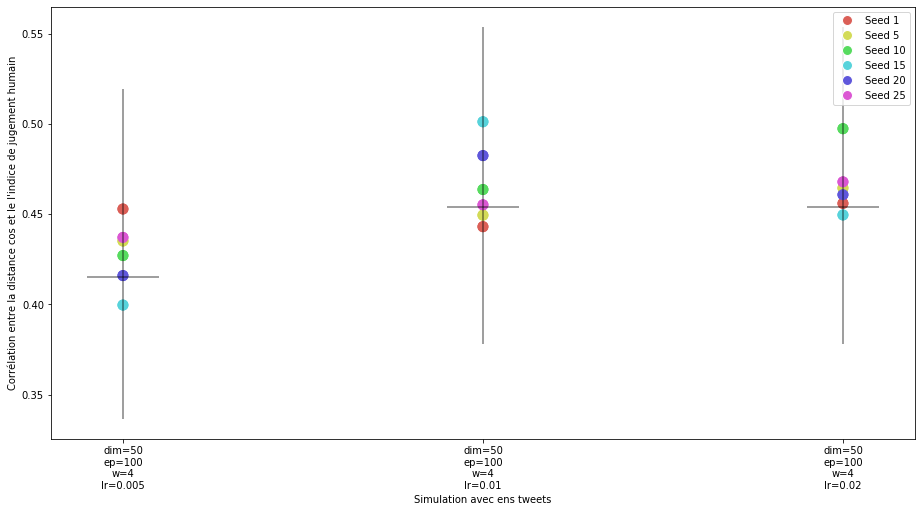

In [62]:
intervalles_confiance(resultats_hji)

0.03296703296703297
-0.010989010989010985
-0.022893772893772892
0.2591575091575091
0.326007326007326
0.2802197802197802
0.3836996336996337
0.3965201465201465
0.4276556776556777
0.3452380952380952
0.3717948717948718
0.3534798534798535


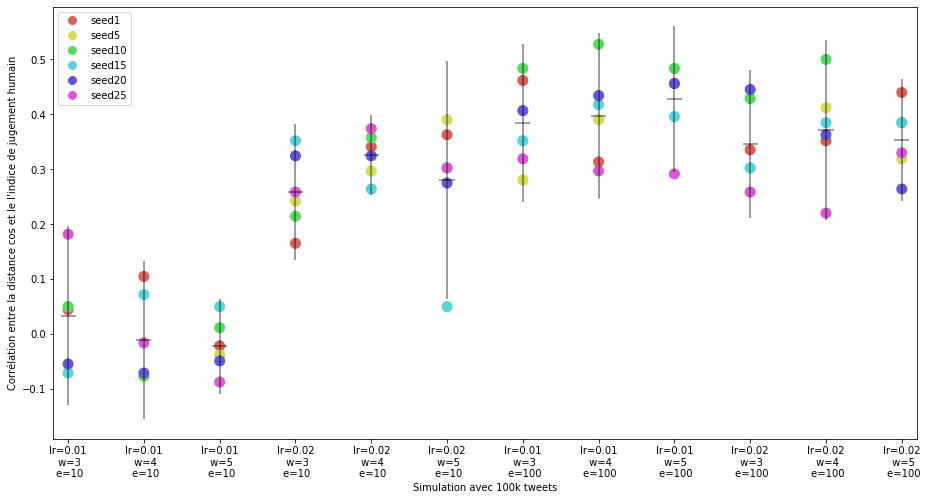

In [25]:
simul2 = [13,14,15,16,17,18,19,20,21,22,23,24]
intervalles_confiance(simul2, "cos")

-0.30036630036630035
-0.26373626373626374
-0.2738095238095238
-0.27930402930402926
-0.2371794871794872
-0.25366300366300365
-0.2371794871794872
-0.2353479853479854
-0.2564102564102564
-0.2692307692307693
-0.2490842490842491
-0.24450549450549453


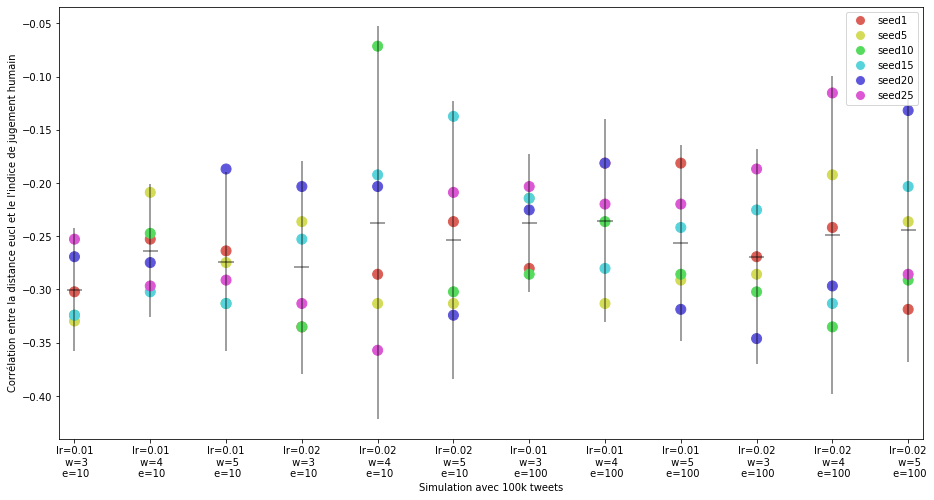

In [26]:
intervalles_confiance(simul2, "eucl")

Fonction Romain provisoire pour tests de représentations graphiques. 

In [ ]:
from matplotlib.lines import Line2D

def intervalles_confiance (resultats_hji, distance = "cos"):
    colors = sns.color_palette("hls", 6)
    fig = plt.figure(figsize = (12,6))    
    ax = fig.add_axes([0.1, 0.1, 1, 1])
    corr = resultats_hji[0]
    corr = corr.reindex(index = ['seed=1','seed=5','seed=10','seed=15','seed=20','seed=25'])
    # ax.set_ylim(-0.5,0.6) # seulement si besoin pour faire des graph comparables
    ax.set_xlim(-0.2,len(corr.columns)-1+.2)

    for i in range(len(corr.columns)):
        corr_values = corr.iloc[:,i].values.tolist()
        ec = np.std(corr_values)
        moy = np.mean(corr_values)
        print(moy)
        icm = moy - 1.96 * ec
        icp = moy + 1.96 * ec
        ax.errorbar(i, moy, yerr=1.96 * ec,ecolor = "black", alpha = 0.5) 
        ax.scatter([i]*len(corr_values), corr_values, c=colors, s = 100) 
        ax.errorbar(i, moy, xerr=0.1, ecolor = "black", alpha= 0.5)
        
    ax.set_xticks(list(range(len(corr.columns))))
    #ax.set_xticklabels(["Simul. n°%i" %simul[i] for i in list(range(len(simul)))])
    ax.set_xticklabels(corr.columns.values.tolist())
    #ax.set_xticklabels(["lr=0.01\n w=3\n e=10","lr=0.01\n w=4\n e=10","lr=0.01\n w=5\n e=10",
    #                    "lr=0.02\n w=3\n e=10","lr=0.02\n w=4\n e=10","lr=0.02\n w=5\n e=10",
    #                    "lr=0.01\n w=3\n e=100","lr=0.01\n w=4\n e=100","lr=0.01\n w=5\n e=100",
    #                    "lr=0.02\n w=3\n e=100","lr=0.02\n w=4\n e=100","lr=0.02\n w=5\n e=100"])
    plt.ylabel("Corrélation entre la distance " + distance + " et le l'indice de jugement humain")
    plt.xlabel("Simulation avec "+ nom_dossier +" tweets")
    custom_lines=[]
    for i in range(len(colors)):
        custom_lines.append(Line2D([0], [0], marker='o', color='w',
                                   label='Scatter',markerfacecolor=colors[i], markersize=10))
    ax.legend(custom_lines, ['Seed 1','Seed 5','Seed 10','Seed 15','Seed 20','Seed 25'])